In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb  
import catboost as cbt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

sys.path.append("../")

from src.features import make_features


In [19]:
BASE_DIR = "../data/processed_data"

In [52]:
# reading data
df = pd.read_csv(f"{BASE_DIR}/AEP_hourly.csv")
df = df.sort_values("timestamp").reset_index(drop=True)

In [76]:
# about features

def generate_basic_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    df["day"] = df["timestamp"].dt.day
    df["month"] = df["timestamp"].dt.month
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)
    return df


def generate_lag_features(df: pd.DataFrame, lags: list[int]) -> pd.DataFrame:
    for lag in lags:
        df[f"target_lag_{lag}"] = df["target"].shift(lag)
    return df


def generate_ewm_features(df: pd.DataFrame, span_list: list[int]) -> pd.DataFrame:
    for span in span_list:
        df[f"target_ewm_span_{span}"] = df["target"].ewm(span=span, adjust=False).mean()
    return df


def generate_rolling_features(df: pd.DataFrame, windows: list[int]) -> pd.DataFrame:
    for window in windows:
        df[f"target_roll_mean_{window}"] = df["target"].rolling(window=window).mean()
        df[f"target_roll_std_{window}"] = df["target"].rolling(window=window).std()
    return df

def generate_derivative_features(df: pd.DataFrame) -> pd.DataFrame:
    df["target_diff_1"] = df["target"].diff()
    df["target_diff_2"] = df["target"].diff().diff()
    df["target_diff_3"] = df["target"].diff().diff().diff()
    return df


def generate_noise_features(df: pd.DataFrame, span_list: list[int]) -> pd.DataFrame:
    for span in span_list:
        var = df["target"].rolling(window=span).var()
        df[f"target_ewm_noise_{span}"] = var.ewm(span=span, adjust=False).mean()
    return df


def make_features(
    df: pd.DataFrame,
    lags: list[int] = [1, 2, 3, 24, 48, 168, 365],
    ewm_spans: list[int] = [2, 3, 6, 12, 24, 168, 365],
    rolling_windows: list[int] = [2, 3, 6, 12, 24, 168],
    noise_spans: list[int] = [3, 6, 12, 24, 168]
) -> pd.DataFrame:
    
    df = generate_basic_time_features(df)
    df = generate_lag_features(df, lags)
    df = generate_derivative_features(df)
    df = generate_ewm_features(df, ewm_spans)
    df = generate_rolling_features(df, rolling_windows)
    df = generate_noise_features(df, noise_spans)

    df["target"] = df["target"].shift(-1)
    df = df.dropna().reset_index(drop=True)
    return df

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

In [77]:
features_df = make_features(df)
X, y = features_df.drop(columns=["target", "timestamp"]), features_df["target"]
# split data into train, valid and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [78]:
# train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1
)
xgb_model.fit(X_train, y_train, 
              eval_set=[(X_valid, y_valid)],
              verbose=None)

mse, rmse, mae, r2 = calculate_metrics(y_test, xgb_model.predict(X_test))
print(f"XGBoost - Test Set - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")
mse, rmse, mae, r2 = calculate_metrics(y_valid, xgb_model.predict(X_valid))
print(f"XGBoost - Valid Set - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

XGBoost - Test Set - MSE: 31277.10, MAE: 134.24, R2: 0.99
XGBoost - Valid Set - MSE: 31537.25, MAE: 134.35, R2: 0.99


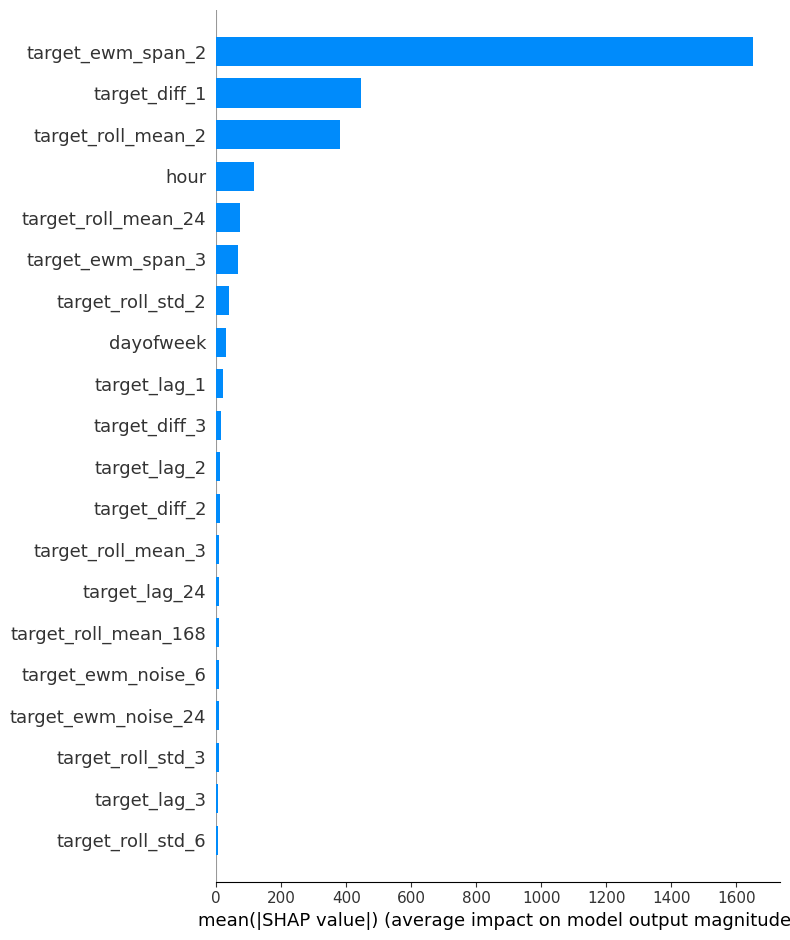

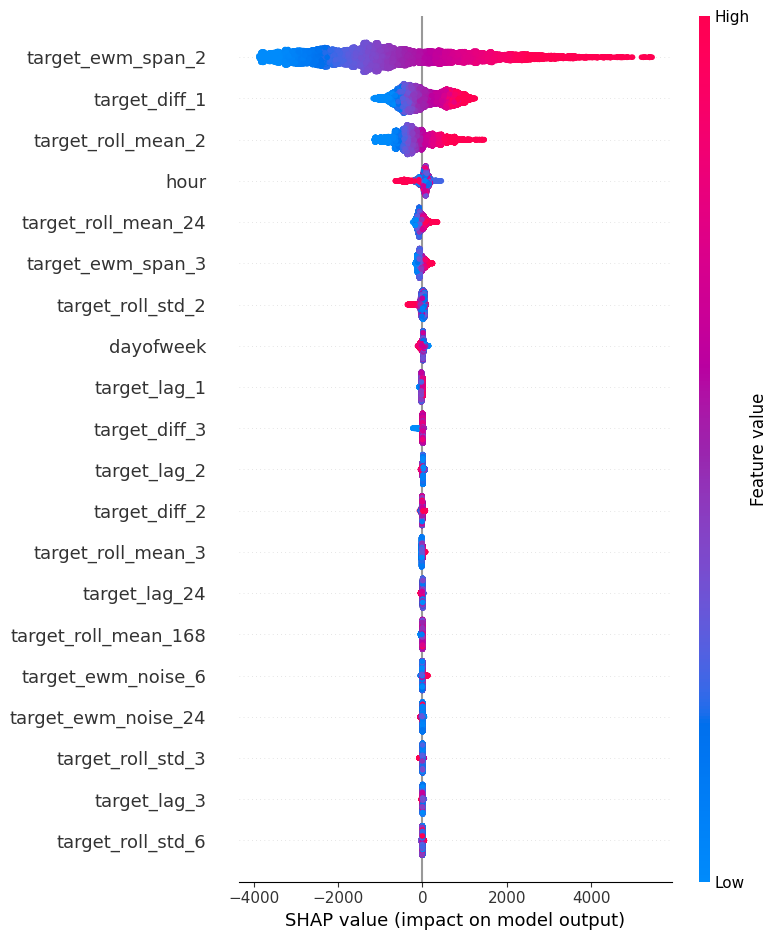

In [79]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_valid, plot_type="bar")
shap.summary_plot(shap_values, X_valid)

In [80]:
# now train CatBoost model
catboost_model = cbt.CatBoostRegressor(
    iterations=1000,
    learning_rate=0.01,
    depth=5,
    l2_leaf_reg=3,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=42,
    verbose=0
)
catboost_model.fit(X_train, y_train,
                   eval_set=(X_valid, y_valid),
                   early_stopping_rounds=100,
                   use_best_model=True)
# calculate metrics on test set
mse, rmse, mae, r2 = calculate_metrics(y_test, catboost_model.predict(X_test))
print(f"CatBoost - Test Set - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")
mse, rmse, mae, r2 = calculate_metrics(y_valid, catboost_model.predict(X_valid))
print(f"CatBoost - Valid Set - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")


CatBoost - Test Set - MSE: 34795.06, MAE: 142.68, R2: 0.99
CatBoost - Valid Set - MSE: 36238.54, MAE: 144.98, R2: 0.99


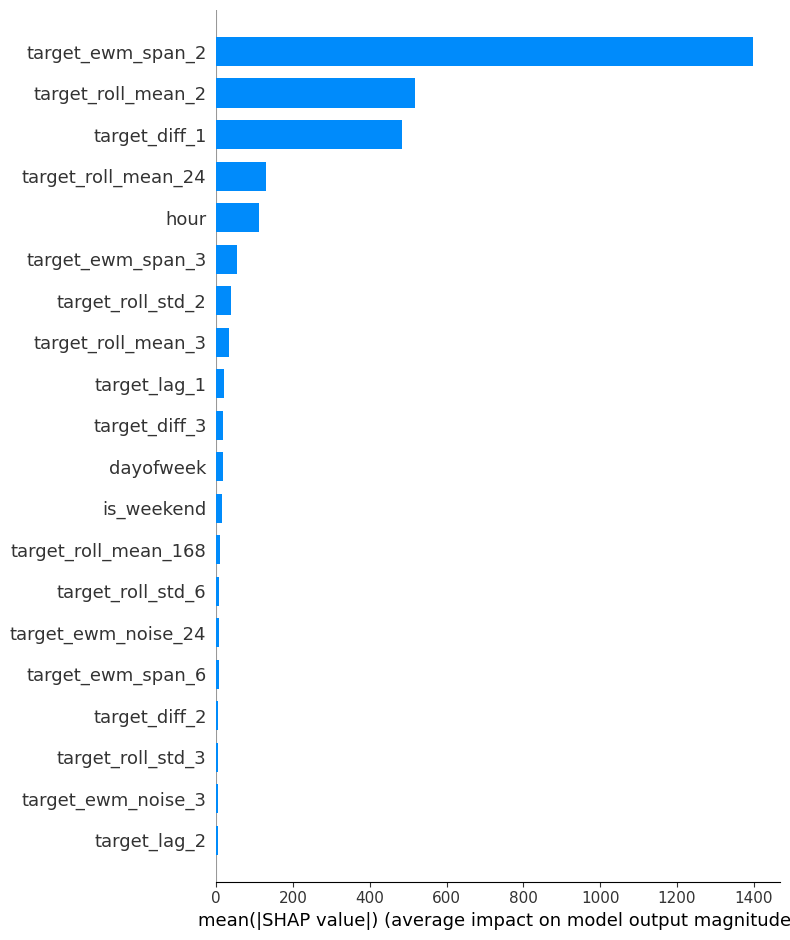

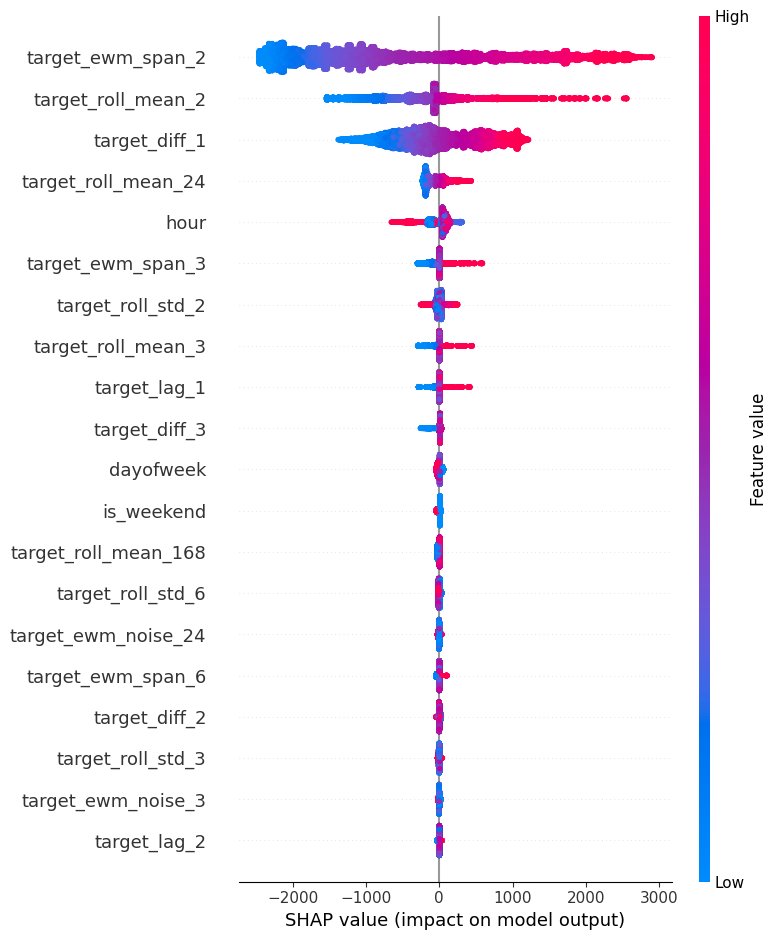

In [81]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_valid, plot_type="bar")
shap.summary_plot(shap_values, X_valid)

In [82]:
# optuna time

In [ ]:
import optuna
from sklearn.metrics import mean_squared_error
from functools import partial

def caboost_objective(trial, X_train, y_train, X_valid, y_valid):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "random_seed": 42,
        "verbose": 0,
        "early_stopping_rounds": 100,
    }

    model = cbt.CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)
    
    preds = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, preds)
    return rmse 


def run_optuna(X_train, y_train, X_valid, y_valid, n_trials=100):
    study = optuna.create_study(direction="minimize", study_name="catboost_tuning")
    objective_func = partial(caboost_objective, X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid)
    study.optimize(objective_func, n_trials=n_trials)

    print("✅ Best parameters:")
    print(study.best_params)
    print(f"📉 Best RMSE: {study.best_value:.4f}")
    
    return study.best_params

In [84]:
best_params = run_optuna(X_train, y_train, X_valid, y_valid)

best_params.update({
    "iterations": 1000,
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": 42,
    "verbose": 100
})

catboost_model = cbt.CatBoostRegressor(**best_params)
catboost_model.fit(X_train, y_train,
                   eval_set=(X_valid, y_valid),
                   use_best_model=True,
                   early_stopping_rounds=100)

[I 2025-05-21 00:32:02,596] A new study created in memory with name: catboost_tuning
[I 2025-05-21 00:32:13,324] Trial 0 finished with value: 21621.9518934661 and parameters: {'learning_rate': 0.016621328160053864, 'depth': 10, 'l2_leaf_reg': 3.055607646754412, 'bagging_temperature': 0.6551142964917485}. Best is trial 0 with value: 21621.9518934661.
[I 2025-05-21 00:32:15,981] Trial 1 finished with value: 19906.934341676828 and parameters: {'learning_rate': 0.07557103267970668, 'depth': 6, 'l2_leaf_reg': 2.1935592841104787, 'bagging_temperature': 0.9126545039345988}. Best is trial 1 with value: 19906.934341676828.
[I 2025-05-21 00:32:26,454] Trial 2 finished with value: 195508.80920746925 and parameters: {'learning_rate': 0.002260199379922955, 'depth': 10, 'l2_leaf_reg': 4.848921107001544, 'bagging_temperature': 0.4976984868319434}. Best is trial 1 with value: 19906.934341676828.
[I 2025-05-21 00:32:29,847] Trial 3 finished with value: 126144.70802006168 and parameters: {'learning_rate

✅ Best parameters:
{'learning_rate': 0.15936286800960403, 'depth': 7, 'l2_leaf_reg': 1.981235494705788, 'bagging_temperature': 0.9473497428907587}
📉 Best RMSE: 17591.7036
0:	learn: 2209.3244741	test: 2315.1042663	best: 2315.1042663 (0)	total: 3.38ms	remaining: 3.37s
100:	learn: 174.8824965	test: 174.3459195	best: 174.3459195 (100)	total: 310ms	remaining: 2.76s
200:	learn: 150.5755575	test: 153.5952103	best: 153.5952103 (200)	total: 614ms	remaining: 2.44s
300:	learn: 139.0003104	test: 145.8086437	best: 145.8086437 (300)	total: 917ms	remaining: 2.13s
400:	learn: 131.2389908	test: 141.3633760	best: 141.3512700 (399)	total: 1.22s	remaining: 1.82s
500:	learn: 125.1624736	test: 138.6863614	best: 138.6847691 (499)	total: 1.53s	remaining: 1.52s
600:	learn: 120.1511106	test: 136.6376755	best: 136.6358892 (599)	total: 1.83s	remaining: 1.22s
700:	learn: 116.1562126	test: 135.1134151	best: 135.1134151 (700)	total: 2.14s	remaining: 913ms
800:	learn: 112.7601483	test: 134.1413854	best: 134.1397588 (

In [85]:
mse, rmse, mae, r2 = calculate_metrics(y_test, catboost_model.predict(X_test))
print(f"CatBoost - Test Set - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")
mse, rmse, mae, r2 = calculate_metrics(y_valid, catboost_model.predict(X_valid))
print(f"CatBoost - Valid Set - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

CatBoost - Test Set - MSE: 19733.21, MAE: 105.92, R2: 1.00
CatBoost - Valid Set - MSE: 17591.70, MAE: 98.51, R2: 1.00


In [88]:
def xgb_objective(trial, X_train, y_train, X_valid, y_valid):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "objective": "reg:squarederror",
        "n_jobs": -1,
        "verbosity": 0,
        "random_state": 42
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

    preds = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, preds)
    return rmse

def run_optuna_xgb(X_train, y_train, X_valid, y_valid, n_trials=50, n_jobs=8):
    study = optuna.create_study(direction="minimize", study_name="xgb_optuna")
    study.optimize(
        lambda trial: xgb_objective(trial, X_train, y_train, X_valid, y_valid),
        n_trials=n_trials,
        n_jobs=n_jobs
    )

    print("✅ Best parameters:")
    print(study.best_params)
    print(f"📉 Best RMSE: {study.best_value:.4f}")
    return study.best_params

In [ ]:
best_params = run_optuna_xgb(X_train, y_train, X_valid, y_valid, n_trials=100)

model = xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

mse, rmse, mae, r2 = calculate_metrics(y_test, model.predict(X_test))
print(f"XGBoost - Test Set - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

[I 2025-05-21 00:44:21,860] A new study created in memory with name: xgb_optuna
[I 2025-05-21 00:44:31,685] Trial 1 finished with value: 226751.27754758258 and parameters: {'n_estimators': 532, 'learning_rate': 0.0051567324816945564, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7467071534606228, 'colsample_bytree': 0.6243033693087033, 'gamma': 3.4648804861556344}. Best is trial 1 with value: 226751.27754758258.
[I 2025-05-21 00:44:32,525] Trial 4 finished with value: 99685.6942086473 and parameters: {'n_estimators': 464, 'learning_rate': 0.007376795185460511, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.5828935380088867, 'colsample_bytree': 0.5350946503106744, 'gamma': 2.826054139136331}. Best is trial 4 with value: 99685.6942086473.
[I 2025-05-21 00:44:32,666] Trial 0 finished with value: 124926.96311593315 and parameters: {'n_estimators': 468, 'learning_rate': 0.006382057450619834, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.5430722147464175, 'colsample_by

✅ Best parameters:
{'n_estimators': 988, 'learning_rate': 0.043709503869569205, 'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.7458649476791913, 'colsample_bytree': 0.8312809401794492, 'gamma': 4.154092608052714}
📉 Best RMSE: 19442.8538
XGBoost - Test Set - MSE: 21529.06, MAE: 109.89, R2: 1.00


In [91]:
mse, rmse, mae, r2 = calculate_metrics(y_valid, model.predict(X_valid))
print(f"XGBoost - Valid Set - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")
mse, rmse, mae, r2 = calculate_metrics(y_test, model.predict(X_test))
print(f"XGBoost - Test Set - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

XGBoost - Valid Set - MSE: 19641.62, MAE: 103.52, R2: 1.00
XGBoost - Test Set - MSE: 21529.06, MAE: 109.89, R2: 1.00
